# Step by step guide to Unit Tests used in this project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from ts_boilerplate.params import ROOT_DIR, DATA, TRAIN, CROSS_VAL
from ts_boilerplate.dataprep import get_X_y, get_folds, train_test_split, get_Xi_yi
from ts_boilerplate.generate_dummy_data import generate_data_monotonic_increase, generate_data_zeros_and_ones, generate_X_y_zeros_and_ones
from ts_boilerplate.model import get_model, fit_model, predict_output
from ts_boilerplate.metrics import mape

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) `generate_dummy_data.py`

Let's create a dummy time series dataset whose value increment by 1 every day

In [2]:
data = generate_data_monotonic_increase()
data

array([[  0.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   1.,   1.],
       [  2.,   2.,   2.,   2.,   2.],
       ...,
       [497., 497., 497., 497., 497.],
       [498., 498., 498., 498., 498.],
       [499., 499., 499., 499., 499.]])

In [3]:
# Store as CSV
data_df = pd.DataFrame(data)
data_df.to_csv(os.path.join(ROOT_DIR, "data", "dummy", "data_dummy.csv"), index=False)
pd.read_csv(os.path.join(ROOT_DIR, "data", "dummy", "data_dummy.csv"))

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,2.0,2.0,2.0,2.0,2.0
3,3.0,3.0,3.0,3.0,3.0
4,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...
495,495.0,495.0,495.0,495.0,495.0
496,496.0,496.0,496.0,496.0,496.0
497,497.0,497.0,497.0,497.0,497.0
498,498.0,498.0,498.0,498.0,498.0


## 2) `dataprep.py`

### 2.1) `getX_y`

In [10]:
X, y = get_X_y(data, **TRAIN)
print(X.shape)
print(y.shape)

(475, 10, 5)
(475, 7, 2)


In [11]:
# Let's compute the shape arithmetically (for unittests)
(len(data) \
            - (TRAIN['input_length']  -1) \
            - (TRAIN['output_length'] -1) \
            - TRAIN['horizon']) \
        / TRAIN["stride"]

475.0

☝️ ceiling rounding function should be used for stride > 1

### 2.2) `train_test_split`

In [12]:
train_test_ratio = TRAIN["train_test_ratio"]
input_length = TRAIN["input_length"]
output_length = TRAIN["output_length"]
data.shape

(500, 5)

In [13]:
last_train_idx = round(train_test_ratio * len(data))
data_train = data[0:last_train_idx, :]

first_test_idx = last_train_idx - input_length
data_test = data[first_test_idx:, :]

In [14]:
data_train

array([[  0.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   1.,   1.],
       [  2.,   2.,   2.,   2.,   2.],
       ...,
       [347., 347., 347., 347., 347.],
       [348., 348., 348., 348., 348.],
       [349., 349., 349., 349., 349.]])

In [ ]:
data_test

In [ ]:
X_train, y_train = get_X_y(data_train, **TRAIN)
X_test, y_test = get_X_y(data_test, **TRAIN)

print("####### Last train pair")
print(X_train[-1])
print(y_train[-1])
print("####### First test pair")
print(X_test[0])
print(y_test[0])

In [17]:
gap = np.min(y_test) - np.max(y_train)
gap

10.0

In [18]:
assert gap >= TRAIN["horizon"], "❗️❗️ Data leak detected between (X_train, y_train) and (X_test, y_test)❗️❗️ "

### 2.3) `get_folds`

In [ ]:
folds = get_folds(data, **CROSS_VAL)
print('n_folds= ', len(folds))
print(folds[-1])

## 3) `model.py`

In [27]:
data_train, data_test = train_test_split(data, **TRAIN)
X_train, y_train = get_X_y(data_train, **TRAIN)
X_test, y_test = get_X_y(data_test, **TRAIN)

In [28]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, SimpleRNN, Reshape, Lambda, Input

In [18]:
# BASELINE: PREDICT LAST VALUE - ZERO TRAINABLE WEIGHTS
input = Input(shape=X_train.shape[1:])
# Take last temporal values of the targets, and duplicate it as many times as `output_length`
x = Lambda(
    lambda x: tf.repeat(tf.expand_dims(tf.gather(x[:, -1, :], indices=DATA['target_column_idx'], axis=1), axis=1),
                        repeats=TRAIN['output_length'],
                        axis=1))(input)
output = Reshape(y_train.shape[1:])(x)
model = Model(input, output)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), metrics=tf.keras.metrics.MAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lambda (Lambda)             (None, 7, 2)              0         
                                                                 
 reshape (Reshape)           (None, 7, 2)              0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=2,
                                        verbose=0,
                                        mode='min',
                                        restore_best_weights=True)
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.3,
                    callbacks=[es],
                    verbose=0)

In [29]:
from ts_boilerplate.metrics import mape

y_pred = model.predict(X_test)
mape(y_test, y_pred)


3.0535266

## 4) `main.py`


### 4.1) `train()`

In [10]:
data = generate_data_monotonic_increase()
data_train, data_test = train_test_split(data, **TRAIN)
X_train, y_train = get_X_y(data_train, **TRAIN)
X_test, y_test = get_X_y(data_test, **TRAIN)
model = get_model(X_train, y_train)
history = fit_model(model, X_train, y_train)
y_pred = predict_output(model, X_test)
metrics_test = mape(y_test, y_pred)

print("### Test Metric: ", metrics_test)

### Test Metric:  3.0535274


### 4.2) cross_validate()

### 4.1) `backtesting()`

In [20]:
y_pred_backtest = []

In [21]:
data = generate_data_monotonic_increase()
from ts_boilerplate.model import get_model, fit_model, predict_output
from ts_boilerplate.dataprep import get_Xi_yi

In [25]:
stride = 10
start_ratio:float = 0.8
retrain: bool = True
retrain_every: int = 50

In [30]:
from tqdm.notebook import tqdm

# Initialization
start_timestep_0 = round(start_ratio * len(data))
data_train_0 = data[:start_timestep_0, ...]
X_train_tmp, y_train_tmp = get_X_y(data_train_0, **TRAIN)
data_test_backtested = data[start_timestep_0:, ...]
_, y_test = get_X_y(data_test_backtested, **TRAIN, shuffle=False)
y_pred_backtested = []
retrain_counter = 0
timesteps_backtested_list = []

for i in tqdm(range(0, len(data_test_backtested), stride)):
    start_timestep_i = start_timestep_0 + i
    data_train = data[:start_timestep_i, ...]
    data_test = data[start_timestep_i:, ...]
    X_train_tmp, y_train_tmp = get_X_y(data_train, **TRAIN)
    X_test_i, y_test_i = get_Xi_yi(first_index=0, data=data_test, **TRAIN)

    # At some point after sliding through time, we will reach the end of the test set
    if y_test_i.shape[0] < y_train_tmp.shape[1]:
        break

    model = get_model(X_train_tmp, y_train_tmp)

    # Retrain when required, with incremental learning (ie. starting from previous weights)
    if retrain and i % retrain_every == 0:
        retrain_counter += 1
        fit_model(model, X_train_tmp, y_train_tmp)

    y_pred_i = np.squeeze(predict_output(model, X_test_i[None, ...]))
    y_pred_backtested.append(y_pred_i)
    timesteps_backtested_list.append(i)

y_pred_backtested = np.array(y_pred_backtested)
y_test_backtested = y_test[timesteps_backtested_list]
# Check that we compare apples to apples
assert y_pred_backtested.shape == y_test_backtested.shape

metrics_backtested = mape(y_pred_backtested, y_test_backtested)

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
print(
    f'### BACKETESTED METRICS BASED ON THE LAST {y_pred_backtested.shape[0]} TIMESTEPS AND WITH {retrain_counter} retrain operations'
)
print(mape(y_pred_backtested, y_test_backtested))


### BACKETESTED METRICS BASED ON THE LAST 8 TIMESTEPS AND WITH 2 retrain operations
2.9357621869726818


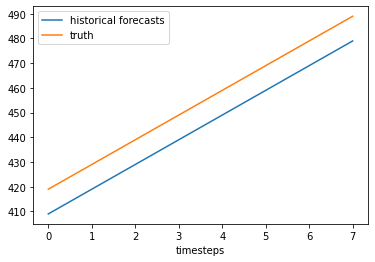

In [32]:
# TODO: make it work for any dimension of y
plt.plot(y_pred_backtested[:,0,0], label='historical forecasts')
plt.plot(y_test_backtested[:,0,0], label='truth')
plt.xlabel('timesteps')
plt.legend()
plt.show()